In [1]:
print("Bisimllah Hirrahamaa Nirraheem")

Bisimllah Hirrahamaa Nirraheem


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import matplotlib.pyplot as plt
import plotly.io as pio
pio.templates["mod"] = go.layout.Template(layout=dict(font=dict(family="Fira Code")))
pio.templates.default = "mod+plotly_dark"
%matplotlib inline

In [3]:
ridership = pd.read_csv("https://data.cityofchicago.org/resource/6iiy-9s97.csv")
ridership.head()

,service_date,day_type,bus,rail_boardings,total_rides
0,2001-01-01T00:00:00.000,U,297192,126455,423647
1,2001-01-02T00:00:00.000,W,780827,501952,1282779
2,2001-01-03T00:00:00.000,W,824923,536432,1361355
3,2001-01-04T00:00:00.000,W,870021,550011,1420032
4,2001-01-05T00:00:00.000,W,890426,557917,1448343


<font face="Fira Code">


# Preprocessing

- Drop total_rides as its just sum of bus and rail_boardings
- Change columns names
- Convert the date column from string to datetime index
- Set and Sort the Date column as the index of the dataframe
- Scale the values of the bus and rail columns using nearest 10 multiple scaling
  - We use the nearest 10 multiple to the largest value to scale is because we want to convert most values between (0,1)

In [4]:
def preprocess_1(data:pd.DataFrame):
    df = data.copy()
    df.drop(columns=['total_rides'],inplace=True)
    df.columns = ['date','day','bus','rail']
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date',inplace=True)
    df.sort_index(inplace=True)
    df[['bus','rail']] /= 1e6
    return df

In [5]:
temp_train = preprocess_1(ridership)
temp_train.head()

,day,bus,rail
date,,,
2001-01-01,U,0.297192,0.126455
2001-01-02,W,0.780827,0.501952
2001-01-03,W,0.824923,0.536432
2001-01-04,W,0.870021,0.550011
2001-01-05,W,0.890426,0.557917


# Visual Insights

In [17]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=temp_train.index,y=temp_train.rail,mode="lines",showlegend=False))
for day  in temp_train.day.unique():
    temp_df = temp_train.query(f"day == '{day}'")
    fig.add_trace(go.Scatter(x=temp_df.index,y=temp_df.rail,mode="markers",name=f"Day:{day}"))

fig.update_layout(title="Train Plot")
fig.show()

<font face="Fira Code">

- The pattern and dependence on day is quite high.
- On Weekends There are a large number of people that go by train 

In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=temp_train.index,y=temp_train.bus,mode="lines",showlegend=False))
for day  in temp_train.day.unique():
    temp_df = temp_train.query(f"day == '{day}'")
    fig.add_trace(go.Scatter(x=temp_df.index,y=temp_df.bus,mode="markers",name=f"Day:{day}"))

fig.update_layout(title="Bus Plot")
fig.show()

<font face="Fira Code">

- This also follows the same pattern as the rail

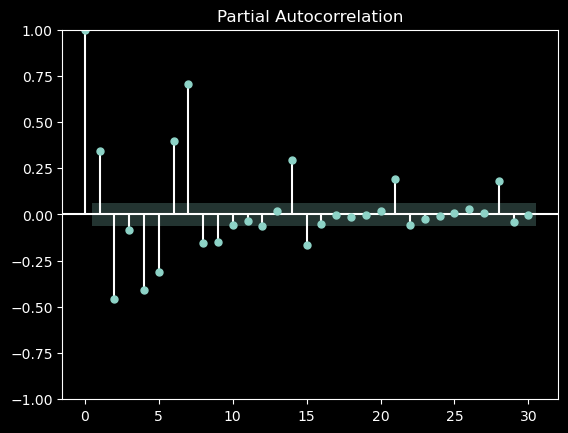

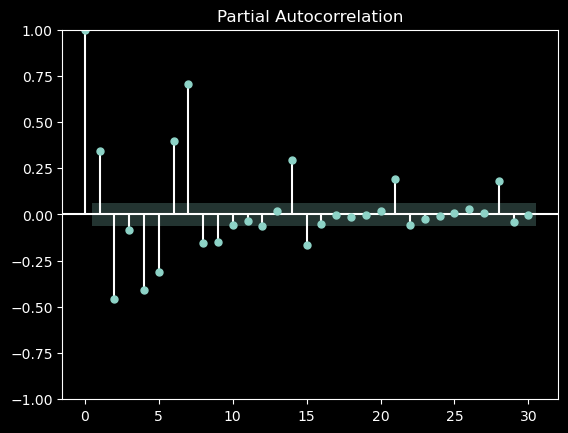

In [7]:
plt.style.use("dark_background")
plot_pacf(temp_train['rail'])

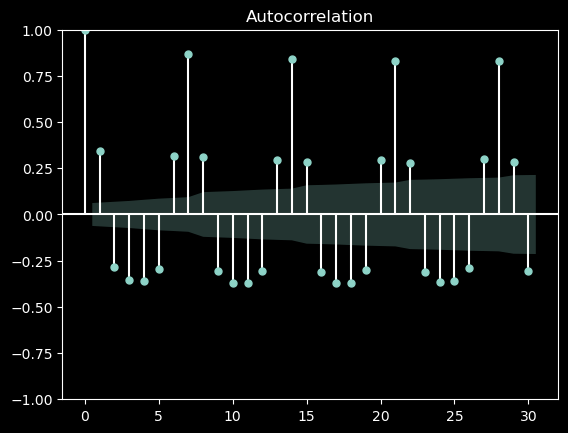

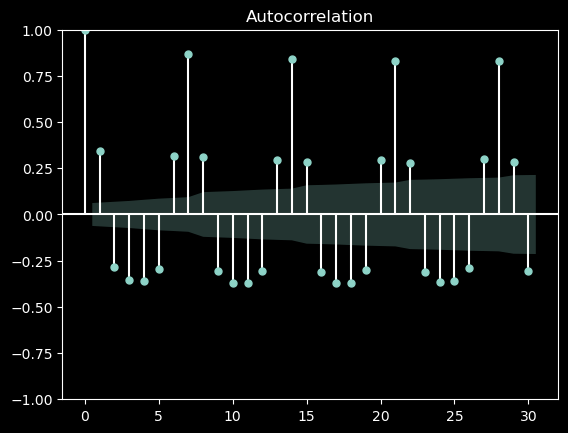

In [8]:
plot_acf(temp_train['rail'])

<font face="Fira Code">

- We found that at lag-7 we get the highest for both pcaf,acf so that is an important factor in analysis
- Changing and appending the new preprocess with the lags for both bus and rail


In [9]:
def preprocess(data:pd.DataFrame):
    df = data.copy()
    df.drop(columns=['total_rides'],inplace=True)
    df.columns = ['date','day','bus','rail']
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date',inplace=True)
    df.sort_index(inplace=True)
    df[['bus','rail']] /= 1e6
    df = pd.get_dummies(df,columns=['day'],dtype=np.float32)
    df['bus_lag'] = df['bus'].shift(7)
    df['rail_lag'] = df['rail'].shift(7)
    df.dropna(inplace=True)
    train_slice = slice("2001","2003-04") # Selecting approx size ratio of 4:1
    valid_slice = slice("2003-05",None)
    return df[train_slice],df[valid_slice]

In [10]:
train_df,valid_df = preprocess(ridership)
display("train first and last",train_df.iloc[[0,-1],:])
print("\n\n")
display("valid first and last",valid_df.iloc[[0,-1],:])

'train first and last'

,bus,rail,day_A,day_U,day_W,bus_lag,rail_lag
date,,,,,,,
2001-01-08,0.985221,0.590706,0.0,0.0,1.0,0.297192,0.126455
2003-04-30,0.828642,0.567596,0.0,0.0,1.0,0.923474,0.613127


'valid first and last'

,bus,rail,day_A,day_U,day_W,bus_lag,rail_lag
date,,,,,,,
2003-05-01,0.971218,0.597161,0.0,0.0,1.0,0.961316,0.620140
2003-09-27,0.591935,0.358390,1.0,0.0,0.0,0.618523,0.338787


In [20]:
def create_seqds(series,ahead=16,seq_l=40,batch_size=32,shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(ahead+1,shift=1,drop_remainder=True).flat_map(lambda x:x.batch(ahead+1))
    ds = ds.window(seq_l,shift=1,drop_remainder=True).flat_map(lambda x:x.batch(seq_l))
    ds = ds.map(lambda x:(x[:,0,:],x[:,1:,1]))
    if shuffle:
        ds = ds.shuffle(batch_size*8)
    ds = ds.batch(batch_size)
    return ds.prefetch(1)

In [32]:
class GatedActivationUnit(keras.layers.Layer):

    def __init__(self,activation_1="tanh",activation_2="sigmoid",**kwargs):

        super(GatedActiavtionUnit,self).__init__(**kwargs)
        self.activation_1=keras.activations.get(activation_1)
        self.activation_2=keras.activations.get(activation_2)
        self.add = keras.layers.Add()

    def call(self,inputs):

        all_filters = (tf.shape(inputs).numpy()[-1])//2
        activation_1_output = self.activation_1(inputs[...,:all_filters])
        activation_2_output = self.activation_2(inputs[...,all_filters:])
        pass

In [21]:
# strategy = tf.distribute.experimental.CentralStorageStrategy()
# with strategy.scope():
#     train_ds = create_seqds(train_df)
#     valid_ds = create_seqds(valid_df,shuffle=False)
#     model = build_model(loss_fn=keras.losses.Huber(),metric_fn="mae")

INFO:tensorflow:ParameterServerStrategy (CentralStorageStrategy if you are using a single machine) with compute_devices = ['/job:localhost/replica:0/task:0/device:CPU:0'], variable_device = '/job:localhost/replica:0/task:0/device:CPU:0'


NameError: name 'build_model' is not defined